In [43]:
import sys
!conda install --yes --prefix {sys.prefix} keras-gpu


Solving environment: done

# All requested packages already installed.



In [1]:
!{sys.executable} -m pip install keras-vis


/bin/sh: 1: {sys.executable}: not found


In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  # Do other imports now...
import keras

Using TensorFlow backend.


In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from IPython.display import clear_output

plt.rcParams['figure.figsize'] = (5, 5)


class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


In [3]:
!nvidia-smi

Sun Dec  8 18:05:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1050    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    N/A /  N/A |    485MiB /  4040MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import cv2
import csv
import numpy as np
import sklearn

data_dir = 'data/'

from sklearn.model_selection import train_test_split

samples = []

with open(data_dir + 'driving_log.csv') as csv_file:        
    reader = csv.reader(csv_file)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples, test_size=0.2)

 
def generator(samples, batch_size=32, measurement_offset=0):
    num_samples = len(samples)
    

    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []

            for batch_sample in batch_samples:
                center_cam = data_dir + './IMG/' + batch_sample[0].split('/')[-1]
                left_cam =  data_dir + './IMG/' + batch_sample[1].split('/')[-1]
                right_cam =  data_dir + './IMG/' + batch_sample[2].split('/')[-1]

                img = cv2.imread(center_cam)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                measurement = float(batch_sample[3])
                #remove anything that comes from turning round off the track
                if measurement > 0.95: 
                    continue
                
                images.append(img)
                measurements.append(measurement)

                img = cv2.flip(img, 1)
                images.append(img)
                measurements.append(-measurement)
               
                
                # left cam
                img = cv2.imread(left_cam)   
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                measurements.append(measurement + measurement_offset)

                ## flip the image
                img = cv2.flip(img, 1)
                images.append(img)
                measurements.append(-(measurement + measurement_offset))

                # right cam
                img = cv2.imread(right_cam)   
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                measurements.append(measurement - measurement_offset)

                 ## flip the image
                img = cv2.flip(img, 1)
                images.append(img)
                measurements.append(-(measurement - measurement_offset))
                
                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# Set our batch size
batch_size = 64

# try and find the best camera offset parameter
measurement_offset = 0.04

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size, measurement_offset=measurement_offset)
validation_generator = generator(validation_samples, batch_size=batch_size,  measurement_offset=measurement_offset)

In [4]:
import os
import csv
import cv2
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation, BatchNormalization, Cropping2D, ELU
from keras.callbacks import ModelCheckpoint, EarlyStopping


def create_model():
    model = Sequential()

    #crop image to lose trees, etc, from top
    model.add(Cropping2D(cropping=((60, 10), (0, 0)), input_shape=(160, 320, 3)))
    #normalize
    model.add(Lambda(lambda x: x / 255.0 - 0.5))
    
    #large filtes and strides, no pooling
    model.add(Conv2D(filters = 24, kernel_size = (8, 8), strides = (4, 4), activation = 'relu', padding = 'same'))
    model.add(Conv2D(filters = 36, kernel_size = (5, 5), strides = (2, 2), activation = 'relu', padding = 'same'))
    model.add(Conv2D(filters = 48, kernel_size = (3, 3), strides = (1, 1), activation = 'relu',  padding = 'same'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3),  activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3),  activation = 'relu'))

    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(rate = 0.2))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(1, activation='linear'))    

    return model



In [5]:
model= create_model()
model.compile(loss='mse', optimizer='adam')
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 23, 80, 24)        4632      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 40, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 40, 48)        15600     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 38, 64)        27712     
_____________________

In [6]:
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = True, mode = 'min')
checkpoint = ModelCheckpoint('models/model-measurement-' + str(measurement_offset) + '-{epoch:03d}-{loss:03f}-{val_loss:03f}.h5', verbose=True, monitor='val_loss', save_best_only=True, mode='auto')  
#model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 10, batch_size = 8, callbacks=[earlyStopping, checkpoint, plot_losses], verbose=True)



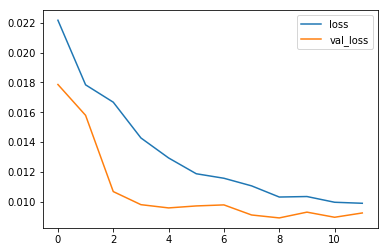

Epoch 00012: early stopping


In [7]:
model.fit_generator(train_generator, 
            steps_per_epoch=np.ceil(len(train_samples)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=np.ceil(len(validation_samples)/batch_size), 
            epochs=20, callbacks=[earlyStopping, checkpoint, plot_losses], verbose = True)


model.save('model' + str(measurement_offset) + '.h5')

In [8]:
model.layers

24


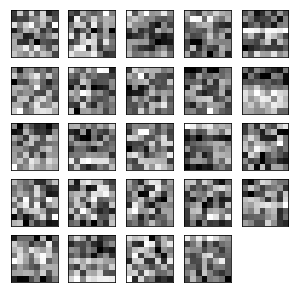

24

In [8]:
filters, biases = model.layers[2].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)


plt.rcParams['figure.figsize'] = (5, 5)

n_filters, ix = filters.shape[-1], 1
print (n_filters)
for i in range(n_filters):
    #get the filter
    f = filters[:, :, :, i]   
    ax = plt.subplot(5, 5, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f[:, :, 2], cmap='gray')
    ix += 1
plt.show()


filters.shape[-1]

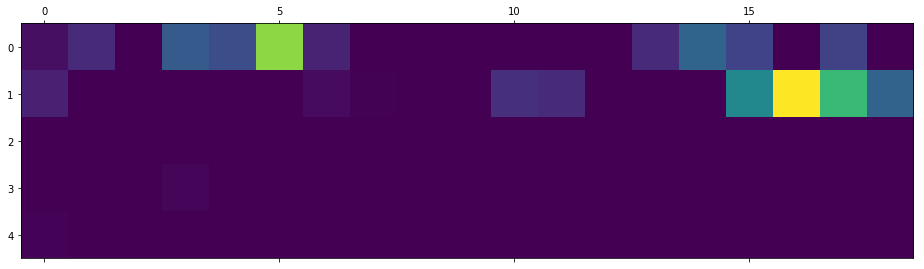

In [15]:
layer_outputs = [layer.output for layer in model.layers[:9]] # Extracts the outputs of the top 12 layers
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
center_cam = samples[1253][0]


img = cv2.imread(center_cam)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)# use the new right turn image

activations = activation_model.predict(np.expand_dims(img,0))
activations

#show some random sample of activations
plt.matshow(activations[6][0, :, :, 12], cmap='viridis')